In [148]:
import dash
from dash import dcc, html, Input, Output
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import numpy as np
import nibabel as nib
from scipy.ndimage import binary_dilation, generate_binary_structure
from sklearn.decomposition import PCA
from skimage.measure import marching_cubes
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial import cKDTree
from collections import defaultdict

# Load the NIfTI file
folder_number = 'C0002'
file_path = os.path.join(r"C:\Users\邱宇辰\OneDrive - Universiteit Utrecht\桌面\Utrecht studying\Team challenge\Aneurysm_TC_data", folder_number, "corrected_segmentation.nii.gz")
nii_file = nib.load(file_path)
seg_data = nii_file.get_fdata()
# Get the coordinates of voxels with values 1 and 2
x1, y1, z1 = np.where(seg_data == 1)  # Cerebral vessels
x2, y2, z2 = np.where(seg_data == 2)  # Aneurysms

# Downsampling function
def downsample_coordinates(x, y, z, factor=2):
    indices = np.arange(0, len(x), factor)
    return x[indices], y[indices], z[indices]

# Downsample coordinates
x1, y1, z1 = downsample_coordinates(x1, y1, z1, factor=2)
x2, y2, z2 = downsample_coordinates(x2, y2, z2, factor=2)



The connection area between cerebral blood vessels and aneurysms is obtained by dilation operation (binary_dilation), and this area is further dilated to make the connection surface thicker. It is used to highlight the surface between cerebral blood vessels and aneurysms.

In [149]:
# Perform additional dilation on the connection region to make the connection surface thicker
def find_thick_connection_region(seg_data, iterations=1):
    # Create masks for vessels and aneurysms
    vessels_mask = (seg_data == 1)
    aneurysms_mask = (seg_data == 2)
    
    # Basic dilation to get the initial connection region
    structure = generate_binary_structure(3, 1)  # 3D connectivity structure
    dilated_vessels = binary_dilation(vessels_mask, structure=structure)
    dilated_aneurysms = binary_dilation(aneurysms_mask, structure=structure)
    connection_region = np.logical_and(dilated_vessels, dilated_aneurysms)
    

    x, y, z = np.where(connection_region)
    return x, y, z

# Use the further dilated connection region
x, y, z = find_thick_connection_region(seg_data, iterations=1)



The normal vector of the connected region is calculated using principal component analysis (PCA). PCA is used to fit the plane of the connected region, and the normal vector is the eigenvector corresponding to the smallest eigenvalue in the PCA method. The orthogonal plane of the normal vector is then drawn.

In [150]:
# Calculate the normal vector of the connected region
def calculate_normal_vector(x, y, z):
    # Combine the coordinates into a set of points
    points = np.vstack((x, y, z)).T
    
    # Use PCA to fit a plane
    pca = PCA(n_components=3)
    pca.fit(points)
    
    # The normal vector is the eigenvector corresponding to the smallest eigenvalue of PCA
    normal_vector = pca.components_[2]
    return normal_vector

# Calculate the normal vector and center point
if len(x) > 0:
    normal_vector = calculate_normal_vector(x, y, z)
    center_x, center_y, center_z = np.mean(x), np.mean(y), np.mean(z)
else:
    normal_vector = np.array([0, 0, 1])  # Default normal vector
    center_x, center_y, center_z = 0, 0, 0  # Default center point

# Generate mesh for cerebral vessels and aneurysms
def generate_mesh(seg_data, label):
    mask = (seg_data == label)
    if np.any(mask):
        verts, faces, _, _ = marching_cubes(mask, level=0.5)
        return verts, faces
    return None, None

# Generate meshes for vessels (label 1) and aneurysms (label 2)
verts1, faces1 = generate_mesh(seg_data, 1)  # Cerebral vessels
verts2, faces2 = generate_mesh(seg_data, 2)  # Aneurysms

# Generate mesh for the (thickened) connected region
def generate_connection_mesh(x, y, z):
    if len(x) > 0:
        # Create a binary mask for the connected region
        connection_mask = np.zeros_like(seg_data, dtype=bool)
        connection_mask[x, y, z] = True
        
        # Generate mesh using marching cubes
        verts, faces, _, _ = marching_cubes(connection_mask, level=0.5)
        return verts, faces
    return None, None

# Generate mesh for the connected region
verts_conn, faces_conn = generate_connection_mesh(x, y, z)

# Calculate the two basis vectors of the orthogonal plane
def calculate_orthogonal_plane(normal_vector):
    # Choose a vector that is not parallel to the normal vector
    if normal_vector[0] != 0 or normal_vector[1] != 0:
        base_vector = np.array([0, 0, 1])
    else:
        base_vector = np.array([1, 0, 0])
    
    # Calculate the first orthogonal vector
    u = np.cross(normal_vector, base_vector)
    u /= np.linalg.norm(u)
    
    # Calculate the second orthogonal vector
    v = np.cross(normal_vector, u)
    v /= np.linalg.norm(v)
    
    return u, v

# Calculate the two basis vectors of the orthogonal plane
u, v = calculate_orthogonal_plane(normal_vector)

# Generate points on the plane
plane_size = 50  # Size of the plane
plane_points = np.array([[center_x + u[0] * i + v[0] * j,
                          center_y + u[1] * i + v[1] * j,
                          center_z + u[2] * i + v[2] * j]
                         for i in range(-plane_size, plane_size + 1, 10)
                         for j in range(-plane_size, plane_size + 1, 10)])

# Generate plane indices for Mesh3d
def generate_plane_indices(plane_size):
    indices = []
    for i in range(plane_size * 2):
        for j in range(plane_size * 2):
            indices.append([i, i + 1, j])
            indices.append([i + 1, j, j + 1])
    return np.array(indices)

plane_indices = generate_plane_indices(plane_size)

# Verify that the plane is orthogonal to the normal vector
def verify_orthogonality(plane_points, normal_vector):
    # Calculate the vector between two points on the plane
    vector_on_plane = plane_points[1] - plane_points[0]
    
    # The dot product should be zero if the plane is orthogonal to the normal vector
    dot_product = np.dot(vector_on_plane, normal_vector)
    return dot_product

# Verify orthogonality
dot_product = verify_orthogonality(plane_points, normal_vector)
print(f"Dot product between plane vector and normal vector: {dot_product}")



Dot product between plane vector and normal vector: -3.1086244689504383e-15


Created a dash app with two main part(3D chart and 2D projection chart). And added a rotation angle adjustment slider to adjust the rotation angle of the 3D view

In [151]:
# Initialize Dash application
app = dash.Dash(__name__)

# Layout
app.layout = html.Div([

    # 3D Visualization
    html.Div([
        html.H3("3D and 2D Projection of Cerebral Vessels and Aneurysms"),
        # Add padding/margin to create space between the plot and angle values
        html.Div(id='camera-angles', style={'padding': '10px', 'font-size': '20px', 'textAlign': 'center', 'margin-bottom': '20px', 'color': 'black'}),
        dcc.Graph(
            id='3d-plot',
            figure=go.Figure(),
            config={'scrollZoom': True, 'displayModeBar': True},
            style={'height': '40vh'}
        )
    ]),

    # 2D Projection with Overlap
    html.Div([
        html.H3("2D Projection View (With Overlap)"),
        dcc.Graph(
            id='2d-plot-overlap',
            figure=go.Figure(),
            config={'displayModeBar': False},
            style={'height': '40vh'}
        )
    ]),

    # 2D Projection without Overlap
    html.Div([
        html.H3("2D Projection View (No Overlap)"),
        dcc.Graph(
            id='2d-plot-no-overlap',
            figure=go.Figure(),
            config={'displayModeBar': False},
            style={'height': '40vh'}
        )
    ]),

    # Angle Adjustment
    html.Div([
        html.Label("Adjust Rotation Angle (0-360°):"),
        dcc.Slider(
            id='angle-slider',
            min=0,
            max=360,
            step=1,
            value=0,
            marks={i: f"{i}°" for i in range(0, 361, 40)},
            tooltip={"placement": "bottom", "always_visible": True}
        )
    ]),

    # Toggle Structures
    html.Div([
        html.Label("Toggle Structures:"),
        dcc.Checklist(
            id='structure-toggle',
            options=[
                {'label': 'Cerebral Vessels', 'value': 'vessels'},
                {'label': 'Aneurysms', 'value': 'aneurysms'},
                {'label': 'Connection Region', 'value': 'connection'},
                {'label': 'Orthogonal Plane', 'value': 'plane'}
            ],
            value=['vessels', 'aneurysms', 'connection', 'plane'],
            inline=True
        )
    ]),
])

Calculate and update the view, including three parts: camera view angle calculation, 2D projection, and depth sorting.

Camera view angle calculation: Calculate the camera's eye position and upward direction based on the normal vector of the connected area and the rotation angle set by the user.

2D projection: Project the 3D points onto the 2D plane and calculate the projection position using the perspective projection rule.

Depth sorting: Sort all projected points according to their distance (depth) from the camera so that they can be correctly superimposed in the 2D graph.

In [152]:
# Calculate camera view
def calculate_camera_view(normal_vector, angle, zoom_factor=1.5):
    angle_rad = np.deg2rad(angle)
    normal_vector = normal_vector / np.linalg.norm(normal_vector)
    u, v = calculate_orthogonal_plane(normal_vector)
    
    # Calculate the eye position based on the angle
    eye = np.cos(angle_rad) * u + np.sin(angle_rad) * v
    eye = eye * zoom_factor
    
    # Camera up direction is the normal vector
    camera_up = normal_vector
    
    # Ensure camera_eye and camera_up are dictionaries
    camera_eye = dict(x=float(eye[0]), y=float(eye[1]), z=float(eye[2]))
    camera_up = dict(x=float(camera_up[0]), y=float(camera_up[1]), z=float(camera_up[2]))
    
    return camera_eye, camera_up

# Calculate the pitch angle
def calculate_pitch_angle(normal_vector, camera_eye):
    # Normalize the normal vector and camera eye vector
    normal_vector = normal_vector / np.linalg.norm(normal_vector)
    camera_eye = np.array([camera_eye['x'], camera_eye['y'], camera_eye['z']])
    camera_eye = camera_eye / np.linalg.norm(camera_eye)
    
    # Calculate the pitch angle using the dot product
    pitch_angle = np.arccos(np.dot(normal_vector, camera_eye))
    return np.rad2deg(pitch_angle)

# Adjust camera view based on pitch angle
def adjust_camera_view(normal_vector, angle, pitch_angle, zoom_factor=1.5):
    angle_rad = np.deg2rad(angle)
    normal_vector = normal_vector / np.linalg.norm(normal_vector)
    u, v = calculate_orthogonal_plane(normal_vector)
    
    # Calculate the eye position based on the angle and pitch angle
    eye = np.cos(angle_rad) * u + np.sin(angle_rad) * v
    eye = eye * zoom_factor
    
    # Adjust the camera up direction based on the pitch angle
    pitch_rad = np.deg2rad(pitch_angle)
    camera_up = normal_vector * np.cos(pitch_rad) + np.cross(eye, normal_vector) * np.sin(pitch_rad)
    
    # Ensure camera_eye and camera_up are dictionaries
    camera_eye = dict(x=float(eye[0]), y=float(eye[1]), z=float(eye[2]))
    camera_up = dict(x=float(camera_up[0]), y=float(camera_up[1]), z=float(camera_up[2]))
    
    return camera_eye, camera_up

# Project 3D points to 2D
def project_to_2d(x, y, z, camera_eye, camera_up):
    camera_eye = np.array([camera_eye['x'], camera_eye['y'], camera_eye['z']])
    camera_up = np.array([camera_up['x'], camera_up['y'], camera_up['z']])
    
    # Normalize camera_eye and camera_up
    camera_eye = camera_eye / np.linalg.norm(camera_eye)
    camera_up = camera_up / np.linalg.norm(camera_up)
    
    # Calculate the right vector (orthogonal to camera_up and camera_eye)
    right = np.cross(camera_up, camera_eye)
    right = right / np.linalg.norm(right)
    
    # Calculate the up vector (orthogonal to camera_eye and right)
    up = np.cross(camera_eye, right)
    up = up / np.linalg.norm(up)
    
    # Stack the 3D points
    points = np.column_stack([x, y, z])
    
    # Project points onto the 2D plane
    projected_x = np.dot(points, right)
    projected_y = np.dot(points, up)
    
    # Calculate depth (distance from camera)
    depth = np.dot(points - camera_eye, camera_eye)
    
    # Handle NaN values
    projected_x = np.nan_to_num(projected_x, nan=0)
    projected_y = np.nan_to_num(projected_y, nan=0)
    depth = np.nan_to_num(depth, nan=0)
    
    return projected_x, projected_y, depth


def calculate_azimuth_elevation(camera_eye):
    azimuth = np.arctan2(camera_eye['y'], camera_eye['x']) * 180 / np.pi
    elevation = np.arctan2(camera_eye['z'], np.sqrt(camera_eye['x']**2 + camera_eye['y']**2)) * 180 / np.pi
    return azimuth, elevation


Update 3D and 2D charts through Dash callback functions. The 3D view and 2D projection map will be dynamically updated when adjust the rotation angle.

In [153]:
# Update the camera angles based on user interaction
@app.callback(
    dash.dependencies.Output('camera-angles', 'children'),
    [dash.dependencies.Input('3d-plot', 'relayoutData')]
)
def update_camera_angles(relayoutData):
    # Ensure relayoutData is not None and contains camera data
    if relayoutData is not None and 'scene.camera' in relayoutData:
        camera = relayoutData['scene.camera']
        if camera:
            eye = camera['eye']
            # Calculate azimuth and elevation
            azimuth = np.arctan2(eye['y'], eye['x']) * 180 / np.pi  # In degrees
            elevation = np.arctan2(eye['z'], np.sqrt(eye['x']**2 + eye['y']**2)) * 180 / np.pi
            return f"Azimuth: {azimuth:.2f}°, Elevation: {elevation:.2f}°", azimuth, elevation
    # Return a default value if relayoutData is None or doesn't contain camera information
    return "Azimuth: 0°, Elevation: 0°", 0, 0

@app.callback(
    [Output('3d-plot', 'figure'), 
     Output('2d-plot-overlap', 'figure'), 
     Output('2d-plot-no-overlap', 'figure')],
    [Input('angle-slider', 'value'), 
     Input('structure-toggle', 'value')]
)
def update_plots(angle, visible_structures):
    fig_3d = go.Figure()
    fig_2d_overlap = go.Figure()
    fig_2d_no_overlap = go.Figure()

    # Add cerebral vessels
    if 'vessels' in visible_structures and verts1 is not None and faces1 is not None:
        fig_3d.add_trace(go.Mesh3d(
            x=verts1[:, 0], y=verts1[:, 1], z=verts1[:, 2],
            i=faces1[:, 0], j=faces1[:, 1], k=faces1[:, 2],
            color='red',
            opacity=0.5,
            name="Cerebral Vessels (Label 1)"
        ))

    # Add aneurysms
    if 'aneurysms' in visible_structures and verts2 is not None and faces2 is not None:
        fig_3d.add_trace(go.Mesh3d(
            x=verts2[:, 0], y=verts2[:, 1], z=verts2[:, 2],
            i=faces2[:, 0], j=faces2[:, 1], k=faces2[:, 2],
            color='blue',
            opacity=0.5,
            name="Aneurysms (Label 2)"
        ))

    # Add connection region
    if 'connection' in visible_structures and verts_conn is not None and faces_conn is not None:
        fig_3d.add_trace(go.Mesh3d(
            x=verts_conn[:, 0], y=verts_conn[:, 1], z=verts_conn[:, 2],
            i=faces_conn[:, 0], j=faces_conn[:, 1], k=faces_conn[:, 2],
            color='green',
            opacity=0.5,
            name="Connection Region"
        ))

    # Add orthogonal plane
    if 'plane' in visible_structures:
        fig_3d.add_trace(go.Mesh3d(
            x=plane_points[:, 0], y=plane_points[:, 1], z=plane_points[:, 2],
            i=plane_indices[:, 0], j=plane_indices[:, 1], k=plane_indices[:, 2],
            color='yellow',
            opacity=0.5,
            name="Orthogonal Plane"
        ))

    # Add normal vector
    if len(x) > 0:
        start_point = np.array([center_x, center_y, center_z])
        end_point = start_point + normal_vector * 50
        fig_3d.add_trace(go.Scatter3d(
            x=[start_point[0], end_point[0]],
            y=[start_point[1], end_point[1]],
            z=[start_point[2], end_point[2]],
            mode='lines',
            line=dict(color='purple', width=3),
            name="Normal Vector"
        ))

    # Calculate camera view
    camera_eye, camera_up = calculate_camera_view(normal_vector, angle, zoom_factor=2)
    pitch_angle = calculate_pitch_angle(normal_vector, camera_eye)
    camera_eye, camera_up = adjust_camera_view(normal_vector, angle, pitch_angle, zoom_factor=2)

    # Project points to 2D
    projected_x1, projected_y1, depth1 = project_to_2d(x1, y1, z1, camera_eye, camera_up)
    projected_x2, projected_y2, depth2 = project_to_2d(x2, y2, z2, camera_eye, camera_up)

    if verts_conn is not None:
        projected_x_conn, projected_y_conn, depth_conn = project_to_2d(verts_conn[:, 0], verts_conn[:, 1], verts_conn[:, 2], camera_eye, camera_up)
    else:
        projected_x_conn, projected_y_conn, depth_conn = np.array([]), np.array([]), np.array([])

    # Combine all points with their labels and depths
    # Combine all points with their labels and depths
    all_points = np.concatenate([
        np.column_stack((projected_x1, projected_y1, depth1, np.zeros_like(depth1))),  # Label 0: Cerebral vessels
        np.column_stack((projected_x2, projected_y2, depth2, np.ones_like(depth2))),   # Label 1: Aneurysms
        np.column_stack((projected_x_conn, projected_y_conn, depth_conn, 2 * np.ones_like(depth_conn)))  # Label 2: Connection region
    ])
    sorted_indices = np.argsort(-all_points[:, 2])  # Sort by depth (descending order)
    sorted_points = all_points[sorted_indices]
    
    # Use KDTree for faster overlap detection
    tree = cKDTree(sorted_points[:, :2])
    overlapping_indices_vessels_aneurysms = set()  # For vessels + aneurysms overlap (pink)
    overlapping_indices_vessels_connection = set()  # For vessels + connection overlap (gold)


    for i, point in enumerate(sorted_points[:, :2]):
        neighbors = tree.query_ball_point(point, r=0.3)  # Adjust radius as needed
        if len(neighbors) > 1:
            # Get labels of neighboring points
            labels = sorted_points[neighbors, 3]
            unique_labels = np.unique(labels)
            
            # Check for vessels + aneurysms overlap
            if 0 in unique_labels and 1 in unique_labels:
                overlapping_indices_vessels_aneurysms.update(neighbors)
            
            # Check for vessels + connection overlap
            if 0 in unique_labels and 2 in unique_labels:
                overlapping_indices_vessels_connection.update(neighbors)

    # Assign colors
    color_map = {0: 'red', 1: 'blue', 2: 'green'}
    colors = np.array([color_map[label] for label in sorted_points[:, 3]])

    # Mark overlapping points
    if len(overlapping_indices_vessels_aneurysms) > 0:
        colors[list(overlapping_indices_vessels_aneurysms)] = 'pink'  # Vessels + aneurysms overlap
    if len(overlapping_indices_vessels_connection) > 0:
        colors[list(overlapping_indices_vessels_connection)] = 'gold'  # Vessels + connection overlap



    # Add 2D projection with overlap after sorting
    fig_2d_overlap.add_trace(go.Scatter(
        x=sorted_points[:, 0],
        y=sorted_points[:, 1],
        mode='markers',
        marker=dict(size=6, color=colors),
        name='2D Projection (With Overlap)'
    ))

    # Add legend traces for the overlap plot
    fig_2d_overlap.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=2, color='red'),
        name="Cerebral Vessels"
    ))
    fig_2d_overlap.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=2, color='blue'),
        name="Aneurysms"
    ))
    fig_2d_overlap.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=2, color='green'),
        name="Connection Region"
    ))
    fig_2d_overlap.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=2, color='pink'),
        name="Overlap (Vessels + Aneurysms)"
    ))
    fig_2d_overlap.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=2, color='gold'),
        name="Overlap (Vessels + Connection)"
    ))

    # Set aspect ratio to equal for the overlap plot
    fig_2d_overlap.update_layout(
        xaxis=dict(scaleanchor="y"),  # This ensures that the x and y axes have the same scale
        yaxis=dict(scaleanchor="x"),
    )

    # Assign colors without overlap (no pink color)
    colors_sorted = np.array([color_map[label] for label in sorted_points[:, 3]])

    # Add 2D projection without overlap
    fig_2d_no_overlap.add_trace(go.Scatter(
        x=sorted_points[:, 0],
        y=sorted_points[:, 1],
        mode='markers',
        marker=dict(size=2, color=colors_sorted),
        name='2D Projection (No Overlap, Sorted by Depth)'
    ))

    # Add legend traces for the no-overlap plot
    fig_2d_no_overlap.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=2, color='red'),
        name="Cerebral Vessels"
    ))
    fig_2d_no_overlap.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=2, color='blue'),
        name="Aneurysms"
    ))
    fig_2d_no_overlap.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='markers',
        marker=dict(size=2, color='green'),
        name="Connection Region"
    ))

    # Set aspect ratio to equal for the no-overlap plot
    fig_2d_no_overlap.update_layout(
        xaxis=dict(scaleanchor="y"),  # This ensures that the x and y axes have the same scale
        yaxis=dict(scaleanchor="x"),
    )

    # Update 3D layout
    fig_3d.update_layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
            camera=dict(
                eye=dict(x=camera_eye['x'], y=camera_eye['y'], z=camera_eye['z']),
                up=dict(x=camera_up['x'], y=camera_up['y'], z=camera_up['z'])
            )
        ),
        title="3D Projection"
    )

    return fig_3d, fig_2d_overlap, fig_2d_no_overlap

# Save images
def save_2d_projection_matplotlib(angle, azimuth, elevation, save_path):
    # Generate the figures
    fig_3d, fig_2d_overlap, fig_2d_no_overlap = update_plots(angle, ['vessels', 'aneurysms', 'connection', 'plane'])
    
    # Extract projection data for the overlap plot (first trace in fig_2d_overlap)
    data_overlap = fig_2d_overlap.data[0]  # The first trace is the projection data with overlap
    x_overlap = data_overlap['x']
    y_overlap = data_overlap['y']
    colors_overlap = data_overlap['marker']['color']
    
    # Create a matplotlib image for the overlap plot
    plt.figure(figsize=(8, 8))  # Increased figure size for clarity
    plt.scatter(x_overlap, y_overlap, c=colors_overlap, s=20, alpha=1.0)  # Fully opaque
    plt.gca().set_aspect('equal', adjustable='box')  # Maintain aspect ratio

    # Ensure axis limits are equal to prevent stretching
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    max_range = max(x_max - x_min, y_max - y_min)
    mid_x = (x_max + x_min) / 2
    mid_y = (y_max + y_min) / 2
    plt.xlim(mid_x - max_range / 2, mid_x + max_range / 2)
    plt.ylim(mid_y - max_range / 2, mid_y + max_range / 2)

    plt.axis('off')  # Disable axes
    plt.tight_layout()

    # Save the overlap plot
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    filename = f"2d_projection_overlap_angle_{angle}_azimuth_{azimuth:.2f}°_elevation_{elevation:.2f}°.png"
    plt.savefig(os.path.join(save_path, filename), bbox_inches=None, pad_inches=0, dpi=700)
    plt.close()

    # Extract projection data for the no-overlap plot (second trace in fig_2d_no_overlap)
    data_no_overlap = fig_2d_no_overlap.data[0]  # The first trace is the projection data without overlap
    x_no_overlap = data_no_overlap['x']
    y_no_overlap = data_no_overlap['y']
    colors_no_overlap = data_no_overlap['marker']['color']
    
    # Create a matplotlib image for the no-overlap plot
    plt.figure(figsize=(8, 8))  # Increased figure size for clarity
    plt.scatter(x_no_overlap, y_no_overlap, c=colors_no_overlap, s=20, alpha=1.0)  # Fully opaque
    plt.gca().set_aspect('equal', adjustable='box')  # Maintain aspect ratio

    # Ensure axis limits are equal to prevent stretching
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    max_range = max(x_max - x_min, y_max - y_min)
    mid_x = (x_max + x_min) / 2
    mid_y = (y_max + y_min) / 2
    plt.xlim(mid_x - max_range / 2, mid_x + max_range / 2)
    plt.ylim(mid_y - max_range / 2, mid_y + max_range / 2)

    plt.axis('off')  # Disable axes
    plt.tight_layout()

    # Save the no-overlap plot
    filename_no_overlap = f"2d_projection_no_overlap_angle_{angle}_azimuth_{azimuth:.2f}°_elevation_{elevation:.2f}°.png"
    plt.savefig(os.path.join(save_path, filename_no_overlap), bbox_inches=None, pad_inches=0, dpi=700)
    plt.close()


def calculate_azimuth_elevation(camera_eye):
    azimuth = np.arctan2(camera_eye['y'], camera_eye['x']) * 180 / np.pi
    elevation = np.arctan2(camera_eye['z'], np.sqrt(camera_eye['x']**2 + camera_eye['y']**2)) * 180 / np.pi
    return azimuth, elevation

# Save images with azimuth and elevation
save_path = os.path.join(r"C:\Users\邱宇辰\OneDrive - Universiteit Utrecht\桌面\Utrecht studying\Team challenge\Aneurysm_TC_data\results_largesize", folder_number + "saved_images")
for angle in range(0, 361, 10):
    # Calculate camera view
    camera_eye, _ = calculate_camera_view(normal_vector, angle, zoom_factor=2)
    azimuth, elevation = calculate_azimuth_elevation(camera_eye)
    
    # Save the 2D projections
    save_2d_projection_matplotlib(angle, azimuth, elevation, save_path)


# Run the app 
if __name__ == '__main__':
    app.run_server(debug=True)



Image with shortest connection region: 2d_projection_no_overlap_angle_60_azimuth_-72.05°_elevation_-55.20°.png
Saving No Overlap (Shortest Connection) to: C:\Users\邱宇辰\OneDrive - Universiteit Utrecht\桌面\Utrecht studying\Team challenge\Aneurysm_TC_data\results_largesize\C0002saved_images\optimal\No_Overlap_(Shortest_Connection)_no_overlap_angle_60_azimuth_-72.05°_elevation_-55.20°.png
Saved No Overlap (Shortest Connection) successfully.


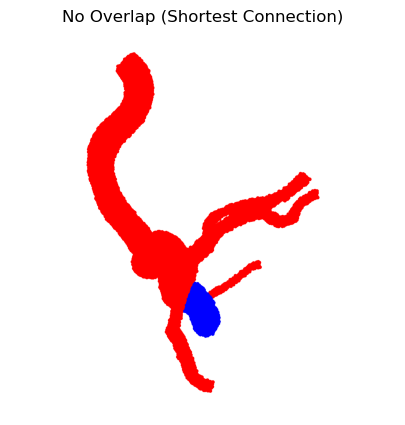

Saving Overlap (Shortest Connection) to: C:\Users\邱宇辰\OneDrive - Universiteit Utrecht\桌面\Utrecht studying\Team challenge\Aneurysm_TC_data\results_largesize\C0002saved_images\optimal\Overlap_(Shortest_Connection)_overlap_angle_60_azimuth_-72.05°_elevation_-55.20°.png
Saved Overlap (Shortest Connection) successfully.


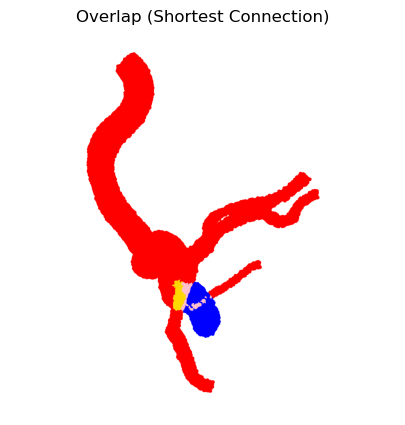


Image with largest aneurysm: 2d_projection_no_overlap_angle_30_azimuth_-53.62°_elevation_-28.30°.png
Saving No Overlap (Largest Aneurysm) to: C:\Users\邱宇辰\OneDrive - Universiteit Utrecht\桌面\Utrecht studying\Team challenge\Aneurysm_TC_data\results_largesize\C0002saved_images\optimal\No_Overlap_(Largest_Aneurysm)_no_overlap_angle_30_azimuth_-53.62°_elevation_-28.30°.png
Saved No Overlap (Largest Aneurysm) successfully.


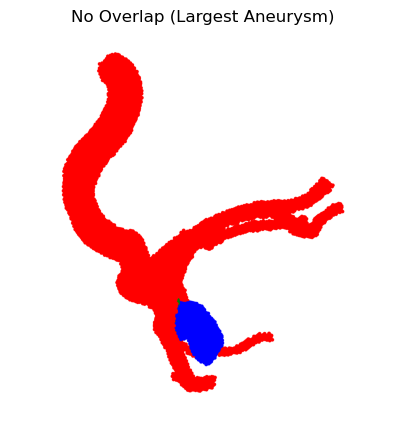

Saving Overlap (Largest Aneurysm) to: C:\Users\邱宇辰\OneDrive - Universiteit Utrecht\桌面\Utrecht studying\Team challenge\Aneurysm_TC_data\results_largesize\C0002saved_images\optimal\Overlap_(Largest_Aneurysm)_overlap_angle_30_azimuth_-53.62°_elevation_-28.30°.png
Saved Overlap (Largest Aneurysm) successfully.


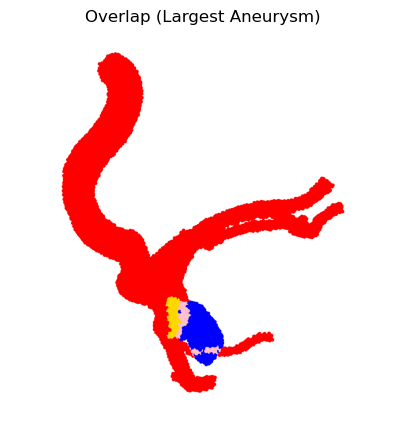

In [ ]:
from PIL import Image
import os
import numpy as np
from matplotlib import image as mpimg
import matplotlib.pyplot as plt

# Define folder path
folder_path = os.path.join(r"C:\Users\邱宇辰\OneDrive - Universiteit Utrecht\桌面\Utrecht studying\Team challenge\Aneurysm_TC_data\results_largesize", folder_number + "saved_images")

# Define color ranges (in RGB format)
red_color = np.array([255, 0, 0])  # Blood vessels
green_color = np.array([0, 128, 0])  # Connection region
blue_color = np.array([0, 0, 255])  # Aneurysm
pink_color = np.array([255, 192, 203])  # Overlap between blood vessels and aneurysm
purple_color = np.array([128, 0, 128])  # Overlap between blood vessels and connection region

# Define color tolerance
tolerance = 50

def count_pixels_by_color(image, target_color, tolerance):
    """Count the pixels of a specific color in the image."""
    image_array = np.array(image)
    color_diff = np.abs(image_array - target_color)
    within_tolerance = np.all(color_diff <= tolerance, axis=-1)
    return np.sum(within_tolerance)

def evaluate_overlap_and_connection(image, connection_color, blood_vessel_color, tolerance=20):
    """Evaluate the overlap of connection region and blood vessel areas."""
    connection_pixels = count_pixels_by_color(image, connection_color, tolerance)
    blood_vessel_pixels = count_pixels_by_color(image, blood_vessel_color, tolerance)
    connection_blood_vessel_overlap = count_pixels_by_color(image, purple_color, tolerance)  # Overlap area
    
    # Handle the special case when connection_pixels is zero
    if connection_pixels == 0:
        if connection_blood_vessel_overlap > 0:
            connection_overlap_percentage = float('inf')  # Infinite overlap ratio
        else:
            connection_overlap_percentage = 0  # No overlap, no connection area
    else:
        connection_overlap_percentage = connection_blood_vessel_overlap / connection_pixels

    return connection_pixels, connection_blood_vessel_overlap, connection_overlap_percentage, blood_vessel_pixels


def process_images(folder_path, result_file):
    """Process images to identify the top 10 with minimal connection overlap, then select top 5 with minimal total overlap."""
    no_overlap_files = [f for f in os.listdir(folder_path) if '2d_projection_no_overlap_' in f and f.endswith('.png')]
    overlap_files = [f for f in os.listdir(folder_path) if '2d_projection_overlap_' in f and f.endswith('.png')]
    
    no_overlap_dict = {f.split('_')[-1].replace('.png', ''): f for f in no_overlap_files}
    overlap_dict = {f.split('_')[-1].replace('.png', ''): f for f in overlap_files}

    # Step 1: Calculate connection overlap percentage and select top 10 images with minimal connection overlap
    connection_overlap_list = []
    for angle, no_overlap_filename in no_overlap_dict.items():
        if angle in overlap_dict:
            overlap_filename = overlap_dict[angle]
            
            no_overlap_image = Image.open(os.path.join(folder_path, no_overlap_filename)).convert('RGB')
            overlap_image = Image.open(os.path.join(folder_path, overlap_filename)).convert('RGB')

            # Evaluate connection overlap
            connection_pixels, connection_blood_vessel_overlap, connection_overlap_percentage, blood_vessel_pixels = evaluate_overlap_and_connection(overlap_image, green_color, red_color)
            
            # Log the results
            result_file.write(f"File (no_overlap): {no_overlap_filename}\n")
            result_file.write(f"File (overlap): {overlap_filename}\n")
            result_file.write(f"connection_overlap_percentage: {connection_overlap_percentage}\n")
            result_file.write(f"connection_pixels: {connection_pixels}\n")
            result_file.write(f"connection_blood_vessel_overlap: {connection_blood_vessel_overlap}\n")
            result_file.write("-" * 30 + "\n")
            
            # Store connection overlap percentage and filenames
            connection_overlap_list.append((connection_overlap_percentage, no_overlap_filename, overlap_filename))

    # Sort by connection overlap percentage (ascending order)
    connection_overlap_list.sort(key=lambda x: x[0])
    top_10_min_connection_overlap = connection_overlap_list[:10]

    # Step 2: From the top 10, select top 5 with minimal total overlap (pink + purple)
    total_overlap_list = []
    for connection_overlap_percentage, no_overlap_filename, overlap_filename in top_10_min_connection_overlap:
        overlap_image = Image.open(os.path.join(folder_path, overlap_filename)).convert('RGB')
        pink_overlap_pixels = count_pixels_by_color(overlap_image, pink_color, tolerance)  # Overlap between blood vessels and aneurysm
        purple_overlap_pixels = count_pixels_by_color(overlap_image, purple_color, tolerance)  # Overlap between blood vessels and connection region
        total_overlap = pink_overlap_pixels + purple_overlap_pixels
        total_overlap_list.append((total_overlap, no_overlap_filename, overlap_filename))

    # Sort by total overlap (ascending order)
    total_overlap_list.sort(key=lambda x: x[0])
    top_5_min_total_overlap = total_overlap_list[:5]

    # Step 3: Apply final selection criteria
    # Criterion 1: Shortest connection region (smallest connection_pixels)
    shortest_connection = min(top_5_min_total_overlap, key=lambda x: count_pixels_by_color(Image.open(os.path.join(folder_path, x[1])).convert('RGB'), green_color, tolerance))

    # Criterion 2: Largest connection region (largest connection_pixels)
    longest_connection = max(top_5_min_total_overlap, key=lambda x: count_pixels_by_color(Image.open(os.path.join(folder_path, x[1])).convert('RGB'), green_color, tolerance))
 
    # Criterion 3: Largest aneurysm (largest blue pixels)
    largest_aneurysm = max(top_5_min_total_overlap, key=lambda x: count_pixels_by_color(Image.open(os.path.join(folder_path, x[1])).convert('RGB'), blue_color, tolerance))

    return shortest_connection, longest_connection, largest_aneurysm

def save_and_display_image(image, title, save_path, original_filename):
    """Save and display the image."""
    plt.figure(figsize=(10, 5))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")

    safe_title = title.replace(' ', '_').replace(':', '').replace('/', '_')
    save_filename = original_filename.replace('2d_projection', safe_title)
    save_full_path = os.path.join(save_path, save_filename)

    print(f"Saving {title} to: {save_full_path}")
    plt.savefig(save_full_path, bbox_inches='tight', pad_inches=0, dpi=700)
    print(f"Saved {title} successfully.")
    plt.show()

def main():
    save_optimal_path = os.path.join(folder_path, "optimal")
    if not os.path.exists(save_optimal_path):
        os.makedirs(save_optimal_path)

    with open(os.path.join(folder_path, 'results.txt'), 'w') as result_file:
        shortest_connection, longest_connection, largest_aneurysm = process_images(folder_path, result_file)

    # Save and display the selected images
    if shortest_connection:
        total_overlap, no_overlap_filename, overlap_filename = shortest_connection
        print(f"\nImage with shortest connection region: {no_overlap_filename}")
        
        # Save and display the no_overlap version
        no_overlap_image = mpimg.imread(os.path.join(folder_path, no_overlap_filename))
        save_and_display_image(no_overlap_image, "No Overlap (Shortest Connection)", save_optimal_path, no_overlap_filename)
        
        # Save and display the overlap version
        overlap_image = mpimg.imread(os.path.join(folder_path, overlap_filename))
        save_and_display_image(overlap_image, "Overlap (Shortest Connection)", save_optimal_path, overlap_filename)
        
    if shortest_connection:
        total_overlap, no_overlap_filename, overlap_filename = longest_connection
        print(f"\nImage with longest connection region: {no_overlap_filename}")
        
        # Save and display the no_overlap version
        no_overlap_image = mpimg.imread(os.path.join(folder_path, no_overlap_filename))
        save_and_display_image(no_overlap_image, "No Overlap (Longest Connection)", save_optimal_path, no_overlap_filename)
        
        # Save and display the overlap version
        overlap_image = mpimg.imread(os.path.join(folder_path, overlap_filename))
        save_and_display_image(overlap_image, "Overlap (Longest Connection)", save_optimal_path, overlap_filename)

    if largest_aneurysm:
        total_overlap, no_overlap_filename, overlap_filename = largest_aneurysm
        print(f"\nImage with largest aneurysm: {no_overlap_filename}")
        
        # Save and display the no_overlap version
        no_overlap_image = mpimg.imread(os.path.join(folder_path, no_overlap_filename))
        save_and_display_image(no_overlap_image, "No Overlap (Largest Aneurysm)", save_optimal_path, no_overlap_filename)
        
        # Save and display the overlap version
        overlap_image = mpimg.imread(os.path.join(folder_path, overlap_filename))
        save_and_display_image(overlap_image, "Overlap (Largest Aneurysm)", save_optimal_path, overlap_filename)

if __name__ == "__main__":
    main()